In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xgboost as xgb
import numpy as np
import prada
import pandas as pd
import veritas
import tree_compress
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', markersize=5)
plt.rc("lines", linewidth=1.0)

## Train models

We use hyperparameter tuning using the grid below to find a reasonable model for each of the datasets.

In [3]:
#dnames = ["Blocksworld_4_64_CA", "Blocksworld_6_64_CA", "Blocksworld_8_64_CA"]
dnames = ["Blocksworld_4_32_CI", "Blocksworld_4_64_CA", "Blocksworld_6_32_CI"]
param_dict = {
    "n_estimators": [20, 30],
    "learning_rate": [0.9, 0.5],
    "subsample": [0.75, 1.0],
    "max_depth": [4, 6]
}

def split_data(d):
    nfolds = max(4, d.X.shape[0] // 40_000)

    dtest, dtrain = d.train_and_test_fold(0, nfolds=nfolds)
    dtrain, dvalid = dtrain.train_and_test_fold(0, nfolds=2)

    return dtrain, dvalid, dtest

In [4]:
best_models = {}
for dname in dnames:
    d = prada.get_dataset(dname, silent=True, seed=12)
    d.load_dataset()
    d.robust_normalize()
    d.astype(np.float32)
    d.astype(np.float64)

    dtrain, dvalid, dtest = split_data(d)

    print("dtrain", dtrain.X.shape)
    print("dtest", dtest.X.shape)
    print("dvalid", dvalid.X.shape)
    
    model_type = "xgb" # or "rf", "lgb"
    model_class = d.get_model_class(model_type)

    models = []
    for i, params in enumerate(d.paramgrid(**param_dict)):
        clf, train_time = dtrain.train(xgb.XGBClassifier, params)
    
        mtrain = dtrain.metric(clf)
        mtest  = dtest.metric(clf)
        mvalid = dvalid.metric(clf)

        #              0  1    2       3      4       5
        models.append((d, clf, mtrain, mtest, mvalid, params))
        
        #print(f" - {i:4d} {dname:10s} train {mtrain*100:5.1f}%, valid {mvalid*100:5.1f}%, test {mtest*100:5.1f}%")

    #best_mvalid = max(models, key=lambda m: m[4])
    #for d, clf, mtrain, mtest, mvalid, params in models:
    #    if abs(mvalid-best_mvalid[4]) < 0.001:
    #        break
    d, clf, mtrain, mtest, mvalid, params = max(models, key=lambda m: m[3])

    best_models[d.name()] = (d, clf, mtrain, mtest, mvalid, params)
    print(f"SELECTED {dname:10s} train {mtrain*100:5.1f}%, valid {mvalid*100:5.1f}%, test {mtest*100:5.1f}%")
    print("params", params, d.X.shape, f"{d.num_classes} classes")
    print()
    
del models

dtrain (3325, 15)
dtest (19949, 15)
dvalid (3324, 15)
SELECTED Blocksworld_4_32_CI train 100.0%, valid 100.0%, test 100.0%
params {'n_estimators': 20, 'learning_rate': 0.9, 'subsample': 1.0, 'max_depth': 6} (26598, 15) 5 classes

dtrain (2105, 15)
dtest (12631, 15)
dvalid (2105, 15)
SELECTED Blocksworld_4_64_CA train 100.0%, valid 100.0%, test  99.8%
params {'n_estimators': 20, 'learning_rate': 0.9, 'subsample': 0.75, 'max_depth': 4} (16841, 15) 5 classes

dtrain (20194, 21)
dtest (242333, 21)
dvalid (20194, 21)
SELECTED Blocksworld_6_32_CI train 100.0%, valid 100.0%, test 100.0%
params {'n_estimators': 20, 'learning_rate': 0.9, 'subsample': 1.0, 'max_depth': 4} (282721, 21) 7 classes



# Compress the models using `tree_compress`

In [5]:
compressed_models = {}
for dname, (d, clf, mtrain, mtest, mvalid, params) in best_models.items():
    dtrain, dvalid, dtest = split_data(d)
    data = tree_compress.Data(
        dtrain.X.to_numpy(), dtrain.y.to_numpy(),
        dtest.X.to_numpy(), dtest.y.to_numpy(),
        dvalid.X.to_numpy(), dvalid.y.to_numpy()
    )
    
    compressed_models[dname] = tree_compress.compress_topdown(
        data, clf, relerr=0.01, silent=True, max_rounds=1,
        return_compress_object=True
    )

    before = compressed_models[dname].records[0]    
    after = compressed_models[dname].records[-1]
    print(f"{dname:10s} number of non-zero leaves: {before.nnz_leafs} -> {after.nnz_leafs},",
          f"test accuracy: {before.mtest*100:.1f}% -> {after.mtest*100:.1f}%")


| XGBOOST's base_score
|   base_score diff std      [9.52985012e-08 1.00035938e-07 2.24042916e-07 5.23076924e-08
 1.37571885e-07] OK
|   base_score reported      0.5
|   versus manually detected [0.52989744 0.50000011 0.49999979 0.50000001 0.50000001]
|   abs err                  [2.98974376e-02 1.07849017e-07 2.08895653e-07 1.09523535e-08
 9.67551028e-09]
|   rel err                  [5.97948752e-02 2.15698034e-07 4.17791307e-07 2.19047069e-08
 1.93510206e-08]
|   (!) base_score NOT THE SAME with relative tolerance 0.001

xtrain shape (3325, 15)
at nlv 5
Blocksworld_4_32_CI number of non-zero leaves: 336 -> 17, test accuracy: 100.0% -> 99.2%

| XGBOOST's base_score
|   base_score diff std      [1.15558187e-07 2.19092288e-07 1.68532140e-07 6.97527299e-08
 7.46396824e-08] OK
|   base_score reported      0.5
|   versus manually detected [0.52188068 0.5000001  0.50000006 0.49999996 0.49999995]
|   abs err                  [2.18806771e-02 9.73343849e-08 5.76861203e-08 4.04989114e-08
 5.15

## Plot the results

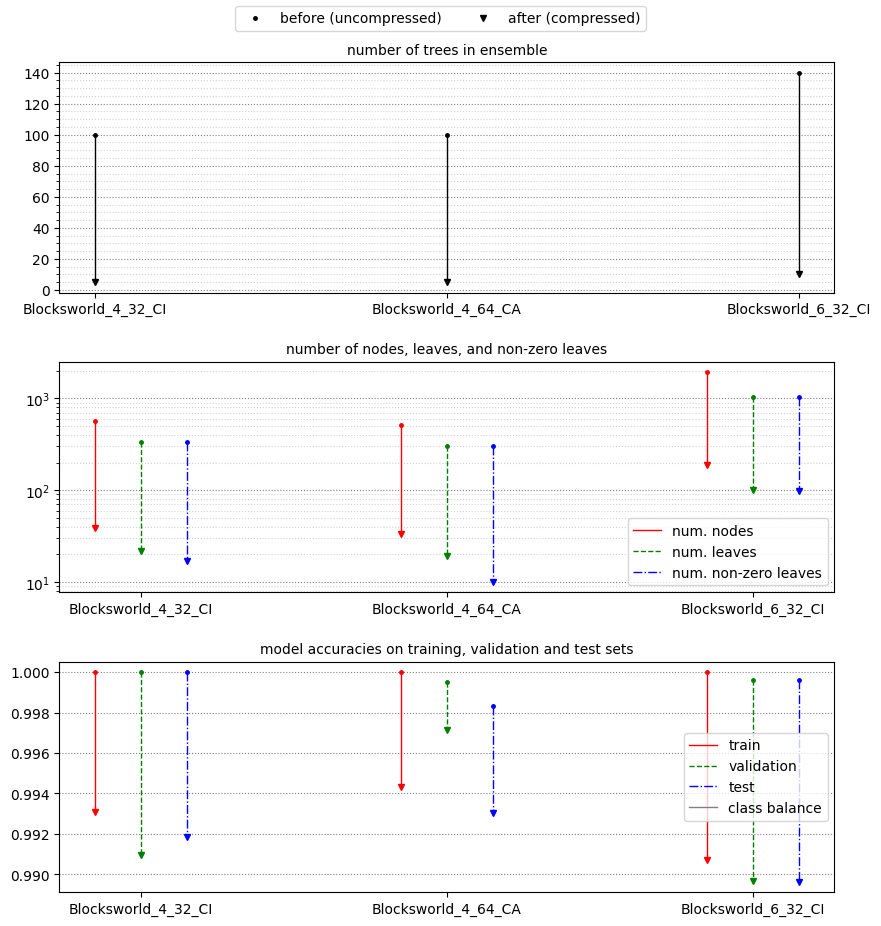

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))

axs[0].set_prop_cycle(color=['black'])
for k in [1, 2]:
    axs[k].set_prop_cycle(color=['red', 'green', 'blue'])

for k, dname, c, (d, clf, mtrain, mtest, mvalid, params) in zip(range(len(compressed_models)),
                                                                compressed_models.keys(),
                                                                compressed_models.values(),
                                                                best_models.values()):
    before = c.records[0]
    after = c.records[-1]

    i = k-0.15
    j = k+0.15
    
    lk, = axs[0].plot(k, before.ntrees, ".")
    axs[0].plot(k, after.ntrees, "v", color=lk.get_color())
    axs[0].plot([k, k], [before.ntrees, after.ntrees],
                color=lk.get_color())
    
    li, = axs[1].plot(i, before.nnodes, ".")
    axs[1].plot(i, after.nnodes, "v", color=li.get_color())
    axs[1].plot([i, i], [before.nnodes, after.nnodes], "-",
                color=li.get_color())
    
    lk, = axs[1].plot(k, before.nleafs, ".")
    axs[1].plot(k, after.nleafs, "v", color=lk.get_color())
    axs[1].plot([k, k], [before.nleafs, after.nleafs], "--",
                color=lk.get_color())

    lj, = axs[1].plot(j, before.nnz_leafs, ".")
    axs[1].plot(j, after.nnz_leafs, "v", color=lj.get_color())
    axs[1].plot([j, j], [before.nnz_leafs, after.nnz_leafs], "-.",
                color=lj.get_color())
    
    li, = axs[2].plot(i, before.mtrain, ".")
    axs[2].plot(i, after.mtrain, "v", color=li.get_color())
    axs[2].plot([i, i], [before.mtrain, after.mtrain], "-",
                color=li.get_color())
    
    lk, = axs[2].plot(k, before.mvalid, ".")
    axs[2].plot(k, after.mvalid, "v", color=lk.get_color())
    axs[2].plot([k, k], [before.mvalid, after.mvalid], "--",
                color=lk.get_color())

    lj, = axs[2].plot(j, before.mtest, ".")
    axs[2].plot(j, after.mtest, "v", color=lj.get_color())
    axs[2].plot([j, j], [before.mtest, after.mtest], "-.",
                color=lj.get_color())

    #classes, class_counts = np.unique(d.y, return_counts=True)
    #class_balance = max(class_counts) / sum(class_counts)
    #axs[2].plot([i, j], [class_balance, class_balance], "-", c="gray")

for k in [0, 1, 2]:
    axs[k].set_xticks(range(len(compressed_models)))
    axs[k].set_xticklabels(list(compressed_models.keys()))
    axs[k].grid(visible=True, axis="y", ls=":", color="gray", which="major")
    axs[k].grid(visible=True, axis="y", ls=":", color="lightgray", which="minor")

fig.legend([
                Line2D([0], [0], c="black", ls="", marker="."),
                Line2D([0], [0], c="black", ls="", marker="v")
           ], [
                "before (uncompressed)",
                "after (compressed)"
           ], loc="upper center", ncols=2)

axs[1].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
           ], [
                "num. nodes",
                "num. leaves",
                "num. non-zero leaves",
           ])

axs[2].legend([
                Line2D([0], [0], c="red", ls="-"),
                Line2D([0], [0], c="green", ls="--"),
                Line2D([0], [0], c="blue", ls="-."),
                Line2D([0], [0], c="gray", ls="-"),
           ], [
                "train",
                "validation",
                "test",
                "class balance",
           ])

axs[0].set_title("number of trees in ensemble")
axs[1].set_title("number of nodes, leaves, and non-zero leaves")
axs[2].set_title("model accuracies on training, validation and test sets")

axs[1].set_yscale("log")
axs[0].yaxis.set_minor_locator(MultipleLocator(5))
axs[2].yaxis.set_minor_locator(MultipleLocator(0.02))

fig.subplots_adjust(top=0.94, hspace=0.3)

plt.show()

**Tabulate** the same results. We use *before* to indicate the results for the uncompressed model, and *after* to indicate the results for the compressed model.

In [7]:
dnames = list(compressed_models.keys())
index_acc = pd.MultiIndex.from_product((dnames, ["before", "after"]))
df = pd.DataFrame("-", columns=["train", "validation", "test",
                                "ntrees", "nnodes", "nleaves", "nnz_leaves",
                                "nleaf_ratio", "nnz_ratio",
                                "test_ratio"], index=index_acc)

for k, (dname, c) in enumerate(compressed_models.items()):
    before = c.records[0]
    after = c.records[-1]

    rbefore = df.loc[(dname, "before"), :]
    rafter = df.loc[(dname, "after"), :]

    rbefore["train"] = np.round(before.mtrain*100, 1)
    rafter["train"] = np.round(after.mtrain*100, 1)
    rbefore["validation"] = np.round(before.mvalid*100, 1)
    rafter["validation"] = np.round(after.mvalid*100, 1)
    rbefore["test"] = np.round(before.mtest*100, 1)
    rafter["test"] = np.round(after.mtest*100, 1)

    rbefore["ntrees"] = before.ntrees
    rafter[ "ntrees"] = after.ntrees
    rbefore["nnodes"] = before.nnodes
    rafter[ "nnodes"] = after.nnodes
    rbefore["nleaves"] = before.nleafs
    rafter[ "nleaves"] = after.nleafs
    rbefore["nnz_leaves"] = before.nnz_leafs
    rafter[ "nnz_leaves"] = after.nnz_leafs
    rafter[ "nleaf_ratio"] = np.round(before.nleafs / after.nleafs, 2)
    rafter[ "nnz_ratio"] = np.round(before.nnz_leafs / after.nnz_leafs, 2)
    rafter[ "test_ratio"] = 1.0-np.round(after.mtest / before.mtest, 4)

display(df)
df_after = df.xs("after", level=1)
display(df_after[["nleaf_ratio", "nnz_ratio", "test_ratio"]].mean(axis=0))

train validation   test ntrees nnodes nleaves  \
Blocksworld_4_32_CI before  100.0      100.0  100.0    100    572     336   
                    after    99.3       99.1   99.2      5     39      22   
Blocksworld_4_64_CA before  100.0      100.0   99.8    100    510     305   
                    after    99.4       99.7   99.3      5     33      19   
Blocksworld_6_32_CI before  100.0      100.0  100.0    140   1928    1034   
                    after    99.1       99.0   99.0     10    190     100   

                           nnz_leaves nleaf_ratio nnz_ratio test_ratio  
Blocksworld_4_32_CI before        336           -         -          -  
                    after          17       15.27     19.76     0.0082  
Blocksworld_4_64_CA before        305           -         -          -  
                    after          10       16.05      30.5     0.0053  
Blocksworld_6_32_CI before       1034           -         -          -  
                    after          99       10.34     10.44       0.01

nleaf_ratio    13.886667
nnz_ratio      20.233333
test_ratio      0.007833
dtype: object

## Checking robustness on the test set

We compute the adversarial accuracy on the original model, and on the pruned model.
We ask the questions:

- How much faster can we do this on the pruned dataset?
- How does pruning affect the robustness of the models?

In [8]:
delta = 0.5
robustness = {}

for dname, c, (d, clf, mtrain, mtest, mvalid, params) in zip(compressed_models.keys(),
                                                             compressed_models.values(),
                                                             best_models.values()):
    dtrain, dvalid, dtest = split_data(d)
    before = c.records[0]
    after = c.records[-1]

    #print()
    #veritas.test_conversion(before.at, dtest.X.to_numpy(), clf.predict_proba(dtest.X)[:,1])

    print("*", dname)

    total_time = [0.0, 0.0]
    count = [0, 0]
    count_wrong = [0, 0]
    count_nonrobust = [0, 0]
    count_to = [0, 0]

    for i in range(min(10000, dtest.X.shape[0])):
        example = dtest.X.iloc[i, :].to_numpy()
        true_label = int(dtest.y.iloc[i])
        prune_box = [veritas.Interval(x-delta, x+delta) for x in example]

        for k, at in enumerate([before.at, after.at]):
            count[k] += 1
            pred_label = np.argmax(at.predict(example))
    
            if true_label != pred_label:
                count_wrong[k] += 1
                continue

            atcpy = at.copy()
            atcpy.swap_class(true_label)
    
            heur = veritas.HeuristicType.MULTI_MIN_MAX_OUTPUT_DIFF
    
            config = veritas.Config(heur)
            config.ignore_state_when_worse_than = 0.0
            search = config.get_search(atcpy, prune_box)
    
            stop_reason = veritas.StopReason.NONE
        
            while search.num_solutions() == 0 \
                    and stop_reason == veritas.StopReason.NONE \
                    and search.time_since_start() < 5.0:
                stop_reason = search.steps(1000)
    
            total_time[k] += search.time_since_start()
    
            raw_pred = 0.0
            if search.num_solutions() > 0 and search.get_solution(0).output > 0.0:
                adv_example = veritas.get_closest_example(search.get_solution(0), example, 1e-5)
                wrong_label = np.argmax(at.predict(adv_example))
                data = np.vstack([example.reshape(1, -1), adv_example.reshape(1, -1)])
                raw_pred_example, raw_pred_adv = at.eval(data)
                if wrong_label == pred_label:
                    print("error: not adversarial??", wrong_label, pred_label, search.get_solution(0).output, search.stats.num_states_ignored)
                    print("bas:", raw_pred_example.round(3), np.argmax(raw_pred_example))
                    print("adv:", raw_pred_adv.round(3), np.argmax(raw_pred_adv))
                    print("distance:", np.max(np.abs(example-adv_example)))
                assert wrong_label != pred_label
                count_nonrobust[k] += 1
            if search.time_since_start() >= 5.0:
                count_to[k] += 1

    print(f"  TOTAL TIME before {total_time[0]:.4f}s after {total_time[1]:.4f}s",
          f"({total_time[0]/total_time[1]:.1f}x)")
    print(f"  ROBUSTNESS before nonrobust {count_nonrobust[0]:4d}, incorrect {count_wrong[0]:4d}, timeout {count_to[0]:4d}, total {count[0]}",
          f"adv acc={100*(1.0-(count_nonrobust[0]+count_wrong[0])/(count[0])):.1f}%")
    print(f"              after nonrobust {count_nonrobust[1]:4d}, incorrect {count_wrong[1]:4d}, timeout {count_to[1]:4d}, total {count[1]}",
          f"adv acc={100*(1.0-(count_nonrobust[1]+count_wrong[1])/(count[1])):.1f}%")

    robustness[dname] = [{
        "total_time": total_time[k],
        "count_nonrobust": count_nonrobust[k],
        "count_wrong": count_wrong[k],
        "count_to": count_to[k],
        "count": count[k],
    } for k in range(2)]

* Blocksworld_4_32_CI
  TOTAL TIME before 0.8730s after 0.1978s (4.4x)
  ROBUSTNESS before nonrobust    0, incorrect    0, timeout    0, total 10000 adv acc=100.0%
              after nonrobust    0, incorrect   83, timeout    0, total 10000 adv acc=99.2%
* Blocksworld_4_64_CA
  TOTAL TIME before 2.9474s after 0.2005s (14.7x)
  ROBUSTNESS before nonrobust    0, incorrect   19, timeout    0, total 10000 adv acc=99.8%
              after nonrobust    0, incorrect   66, timeout    0, total 10000 adv acc=99.3%
* Blocksworld_6_32_CI
  TOTAL TIME before 5.3789s after 0.4742s (11.3x)
  ROBUSTNESS before nonrobust    0, incorrect    6, timeout    0, total 10000 adv acc=99.9%
              after nonrobust    0, incorrect   98, timeout    0, total 10000 adv acc=99.0%


In [9]:
# Tabulate
dnames = list(compressed_models.keys())
index_acc = pd.MultiIndex.from_product((dnames, ["before", "after"]))
dfrob = pd.DataFrame("-", columns=["wrong", "nonrobust", "total", "adv.acc", "time", "speedup"], index=index_acc)

for k, (dname, results) in enumerate(robustness.items()):
    before = c.records[0]
    after = c.records[-1]

    for j, jj, res in zip(range(2), ["before", "after"], results):
        r = dfrob.loc[(dname, jj), :]
        rafter = dfrob.loc[(dname, "after"), :]

        r["wrong"] = res["count_wrong"]
        r["nonrobust"] = res["count_nonrobust"]
        r["total"] = res["count"]
        #r["timeout"] = res["count_to"]
        r["adv.acc"] = np.round(100.0 - 100*(res["count_wrong"] + res["count_nonrobust"]) / res["count"], 1)
        r["time"] = np.round(res["total_time"], 2)

    dfrob.loc[(dname, "after"), "speedup"] = np.round(results[0]["total_time"] / results[1]["total_time"], 1)

display(dfrob)

wrong nonrobust  total adv.acc  time speedup
Blocksworld_4_32_CI before     0         0  10000   100.0  0.87       -
                    after     83         0  10000    99.2   0.2     4.4
Blocksworld_4_64_CA before    19         0  10000    99.8  2.95       -
                    after     66         0  10000    99.3   0.2    14.7
Blocksworld_6_32_CI before     6         0  10000    99.9  5.38       -
                    after     98         0  10000    99.0  0.47    11.3

We again use *before* to indicate the results for the uncompressed model, and *after* to indicate the results for the compressed model.